In [31]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#PCA as best practice to reduce dimensionality first
#as well as check for fitting amount of Gaussians / clusters
from sklearn.decomposition import PCA

#skaler
from sklearn.preprocessing import StandardScaler
#kmeans (hard)
from sklearn.cluster import KMeans
#kmeans with expectation maximization (hard)
from sklearn.metrics import pairwise_distances_argmin
#GMM (soft)
from sklearn.mixture import GaussianMixture


In [59]:
path_output=os.path.join(os.getcwd(), '../data/output/')

## Data preparation

In [60]:
df = pd.read_csv(os.path.join(path_output, "Trips.csv"))

In [61]:
df = df.drop(['Unnamed: 0'], axis=1)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567439 entries, 0 to 567438
Data columns (total 38 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   p_bike_racks_start     567439 non-null  int64  
 1   p_spot_start           567439 non-null  bool   
 2   p_booked_bikes_start   567439 non-null  int64  
 3   p_place_type_start     567439 non-null  int64  
 4   datetime_start         567439 non-null  object 
 5   b_number_start         567439 non-null  int64  
 6   p_uid_start            567439 non-null  int64  
 7   p_bikes_start          567439 non-null  int64  
 8   p_lat_start            567439 non-null  float64
 9   b_electric_lock_start  567439 non-null  bool   
 10  b_bike_type_start      567439 non-null  int64  
 11  p_name_start           567439 non-null  object 
 12  p_free_racks_start     567439 non-null  int64  
 13  b_lock_types_start     567439 non-null  object 
 14  p_number_start         567377 non-nu

Text(0.5, 1.0, 'January')

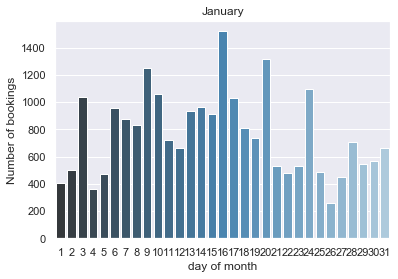

In [70]:
df["datetime_start"] = pd.to_datetime(df["datetime_start"].astype(str), format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_full = df


#Distribution Number of bookings per month
# df_full.datetime_start.dt.day.value_counts()
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 1].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('January')


## Task description - Cluster analysis

- Based on the bike rental demand patterns, can you identify clusters of **trip types and/or customer types**? 
- How would you **label** these clusters? 
- Can you identify **hot spots for vehicle availability and demand in spatial resolution**?
- Method 1: soft-clustering 
- Method 2: hard-clustering
- Create **visual comparison** of both methods 

#### Similar paper:
--> difference of usage patterns among user groups, turnover rate, travel time and distance
--> combined with spatial POI data with categories like: Catering, Hotel, Shopping, Living Service,
Tourist Sites, Leisure and Entertainment, Education, Medical, Trafficc Facilities, Financial Institutions,
Real Estate, Corporations, and Government Institutions.

### Columns for trip types:
- stations like University or main station
- trip duration
- bike IDs
- datetime
- weather data

### Columns for customer types:
- stations like University or main station
- trip duration
- user IDs
- datetime
- weather data

### Columns for spatial Vehicle availability & demand
- ??


## 1) Hard Clustering
- Kmeans: 
An iterative method, k-means algorithm is the most fundamental and most useful algorithm for
clustering [36]. For a given number of clusters, it can minimize the within-class sum of squares [37].
Its effciency to a great extent relies on the choice of the cluster centers. When the algorithm starts,
random procedures are applied to create starting clustering centers, then each observation is put
in its closest cluster. Therefore, the cluster centers are updated, and the entire process is repeated,
finally, objects are relocated by minimizing the distances of objects within clusters and maximizing the
distance of objects in different clusters.

- Expectation Maximization: 
A model-based clustering, EM clustering functions with a Gaussian mixture model. This model is
extended from the k-means algorithm [38]. K-means only takes into account the distance to the closest
cluster when assigning points to clusters. Yet EM clustering also computes the probability that a point
belongs to a cluster. As the probability depends on both the distance from the cluster center and the
spread (variance) of the cluster, a point that is closer to the centroid of one cluster than another may
well become more likely to belong to the latter cluster if it has a much higher spread [38].


In [43]:
#Trip types clustering
duration_weather = ["trip_duration", "air_deg", "air_hum" , "rain_mm" , "rain_yn" , "sun_hour", "wind_ms"]
df_full = df[duration_weather]
df_full

#standardize StandardScaler
scaler = StandardScaler()
scaler.fit(df_full)
X_scaled = scaler.transform(df_full)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_full.columns, index=df_full.index)

In [45]:
#standard kmeans approach

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_full)
y_kmeans = kmeans.predict(df_full)
labels = kmeans.labels_

#Glue back to originaal data
df_full['clusters'] = labels

#Add the column into our list
duration_weather.extend(['clusters'])

#Lets analyze the clusters
print (df_full[duration_weather].groupby(['clusters']).mean())

C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


          trip_duration    air_deg    air_hum   rain_mm   rain_yn   sun_hour  \
clusters                                                                       
0             14.906776  19.788024  47.946432  0.000318  0.002850  50.915687   
1            163.329328  17.314945  57.031169  0.030263  0.059289  30.027227   
2             11.400240  11.798776  71.674500  0.054493  0.126796   2.708403   
3            472.453726  13.682937  67.893967  0.025307  0.063008  23.769178   

           wind_ms  
clusters            
0         4.363248  
1         4.145763  
2         4.081680  
3         3.691046  


Text(29.95656006944445, 0.5, 'Air deg')

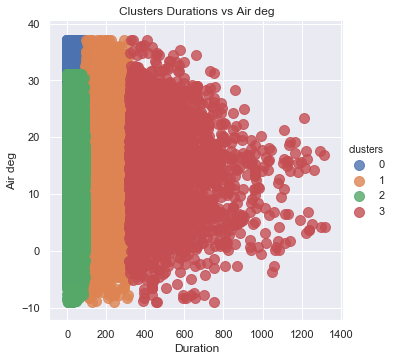

In [47]:
#Scatter plot of Wattage and Duration
sns.lmplot('trip_duration', 'air_deg', 
           data=df_full, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters Durations vs Air deg')
plt.xlabel('Duration')
plt.ylabel('Air deg')


## 2) Soft Clustering
- Gaussian Mixture Models:
Even more powerful than EM Clustering, can identify moonshaped clusters etc.

In [52]:
X = df_full

In [53]:
#advanced EM (kmeans) approach
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    # Choose randomly n_clusteres elements from the input list X
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        #print(labels)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

# centers, labels = find_clusters(X, 4)
# plt.scatter(X[:, 0], X[:, 1], c=labels,
#             s=50, cmap='viridis');

In [54]:
#standrad GMM approach
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
#plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

#visualize probabilites
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
